https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#fast-gradient-method-fgm
https://arxiv.org/pdf/1412.6572.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset
from art.estimators.classification import KerasClassifier #No soporta TF 2

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

In [2]:
vulnerable_model = tf.keras.models.load_model("modelo_victima1")

In [3]:
#Se utilizara una version del dataset del MNIST con 60k digitos a mano que incluye ART
(train_images, train_labels), (test_images, test_labels), min, max = load_dataset(name="mnist")

In [4]:
clasificador = KerasClassifier(
    model=vulnerable_model,
    clip_values=(min, max))

In [5]:
#Ataque usando Gradiente Descendiente para generar imagenes adversariales
#Epsilon define que tan fuerte será el ataque:
#Debe haber un equilibrio entre la fuerza del ataque y la detección a simple vista que permita detectar que una imagen fue atacada

attack_fgsm = FastGradientMethod(
    estimator=clasificador, 
    eps=0.9
    )

In [6]:
test_images_adv = attack_fgsm.generate(x=test_images)

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


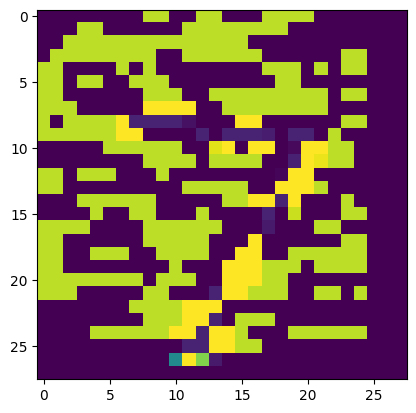

In [7]:
plt.imshow(X=test_images_adv[0])

In [8]:
# Evaluating the model on clean images
score_clean = vulnerable_model.evaluate(
    x=test_images, 
    y=test_labels
    )

# Evaluating the model on adversarial images
score_adv = vulnerable_model.evaluate(
    x=test_images_adv, 
    y=test_labels
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} " 
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} " 
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")


C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Clean test set loss: 0.04 vs adversarial set test loss: 19.38
Clean test set accuracy: 0.99 vs adversarial test set accuracy: 0.06


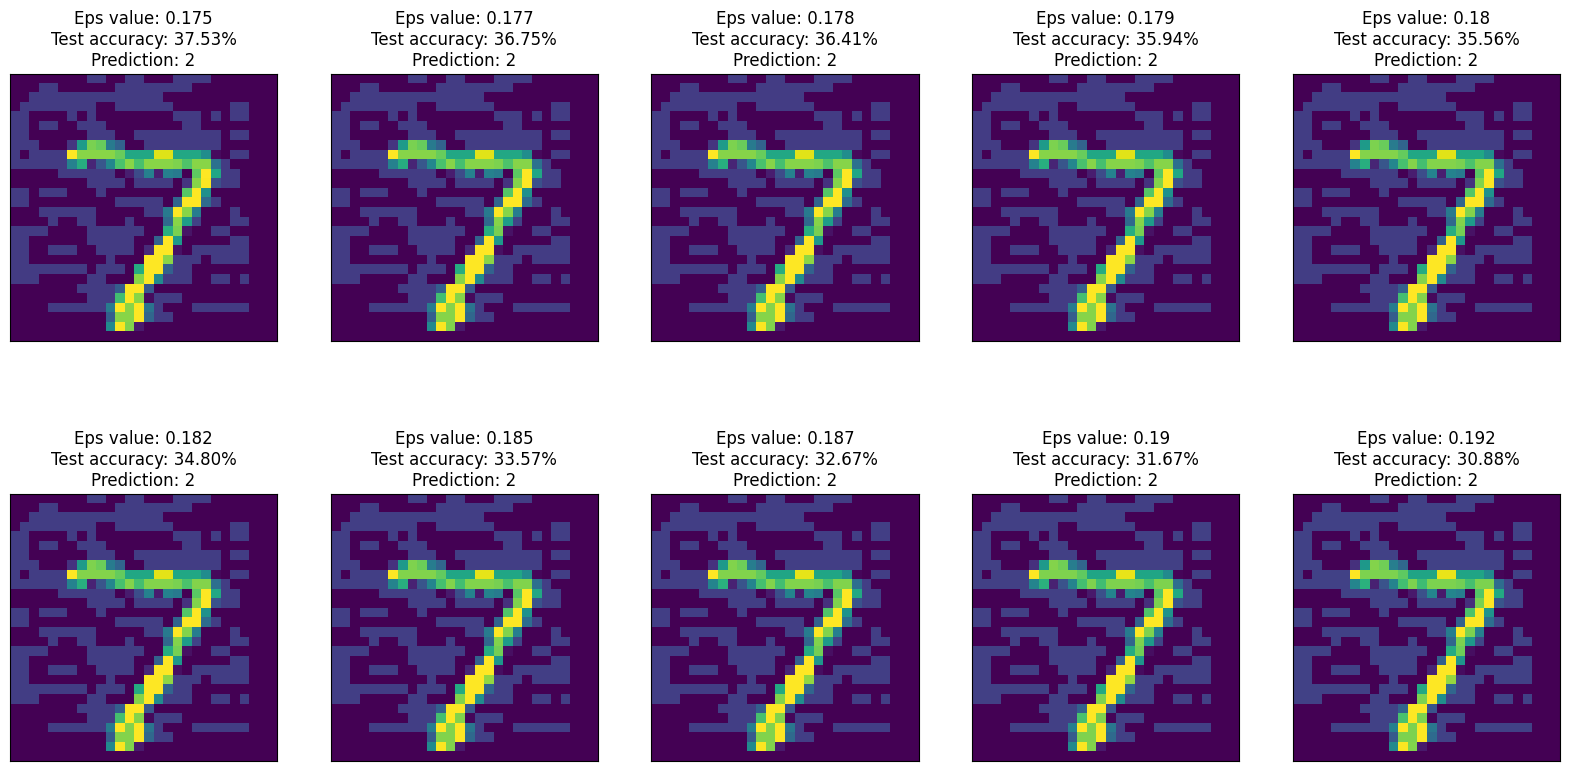

In [9]:
#Se prueba el accuracy para distintos valores de epsilon

# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Defining a range of eps values to try
#eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]
eps_to_try = [0.175, 0.177, 0.178, 0.179, 0.18, 0.182, 0.185, 0.187, 0.19, 0.192]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):    
        # Creating an attack object for the current value of eps    
        attack_fgsm = FastGradientMethod(
            estimator=clasificador, 
            eps=eps_to_try[counter]
            )

        # Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=test_images)

        # Showing the first adversarial image
        axes[i, j].imshow(X=test_images_adv[0])

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = clasificador._model.evaluate(
            x=test_images_adv, 
            y=test_labels
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(vulnerable_model.predict(
            x=np.expand_dims(a=test_images_adv[0], 
            axis=0)
            ))    

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()